In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, cluster
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, Normalizer
sns.set(style="darkgrid")

In [2]:
%run clustering-methods.ipynb

In [3]:
minute_interval = 15
non_reoccuing_number = 100
linkage_methods = ['ward', 'complete', 'average', 'single']
document_features_name = "value"
used_features = ['mean','std','skew','l1','l2','l3','c95']

In [4]:
ts_data = pd.read_csv(f"../../../data/corrected_data_{minute_interval}_{non_reoccuing_number}.csv")

In [5]:
ts_data['date'] = pd.to_datetime(ts_data['date'])
ts_data['ndt'] = pd.to_datetime(ts_data.date) + ts_data.hours.astype('timedelta64[h]') + ts_data.minutes.astype('timedelta64[m]')

In [6]:
features = pd.read_csv(f"../../../data/features_{minute_interval}_{non_reoccuing_number}.csv")
features['non-zero-ratio'] = features['non-zero-occurances'] / features['occurances']
features = features.fillna(0)

In [7]:
features_cl = features.drop(columns=['hash'])

In [8]:
global_date_range = pd.date_range(start=ts_data.date.min().date(), end=ts_data.date.max().date())

## Value-based features

In [9]:
print(used_features)

['mean', 'std', 'skew', 'l1', 'l2', 'l3', 'c95']


In [10]:
features_reduced = features_cl[used_features]

In [11]:
r_scaler = StandardScaler().fit(features_reduced)
features_reduced_scaled = r_scaler.transform(features_reduced)
r_normalizer = Normalizer().fit(features_reduced_scaled)
features_rsn = pd.DataFrame(r_normalizer.transform(features_reduced_scaled))
features_rsn.columns = used_features

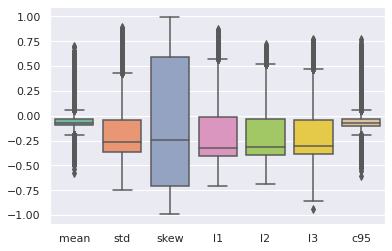

In [12]:
sns.boxplot(data=features_rsn, palette="Set2")

## Method dendograms

In [13]:
fig, ax = plt.subplots(1, len(linkage_methods))
fig.set_size_inches(24, 8)
for i, method in enumerate(linkage_methods):
    fitted_model = fit_model(features_rsn, method)
    model_dendogram(fitted_model, 5, ax=ax[i])
    ax[i].set_title(f'Method: {method}, Data: Scaled and normalized')

## Single linkage

In [14]:
model_single_rsn = fit_model(features_rsn, 'single', 12, None)
clusters_single_rsn = model_single_rsn.fit_predict(features_rsn)
print(cluster_sizes(clusters_single_rsn))

[13022     1     2     1     1     1     1     1     1     1     1     1]


## Average linkage

In [15]:
model_average_rsn = fit_model(features_rsn, 'average', 12, None)
clusters_average_rsn = model_average_rsn.fit_predict(features_rsn)
print(cluster_sizes(clusters_average_rsn))

[2217 6401   22 3818   12   12  413   28   68   20   22    1]


In [18]:
plot_cluster_comparison(ts_data, features_rsn, features, clusters_average_rsn, w=16, h=26, boxplot_drop=[])

## Complete linkage

In [16]:
model_complete_rsn = fit_model(features_rsn, 'complete', 12, None)
clusters_complete_rsn = model_complete_rsn.fit_predict(features_rsn)
print(cluster_sizes(clusters_complete_rsn))

[2836  249 1193  177   24  549   21 1945 1123  352 4314  251]


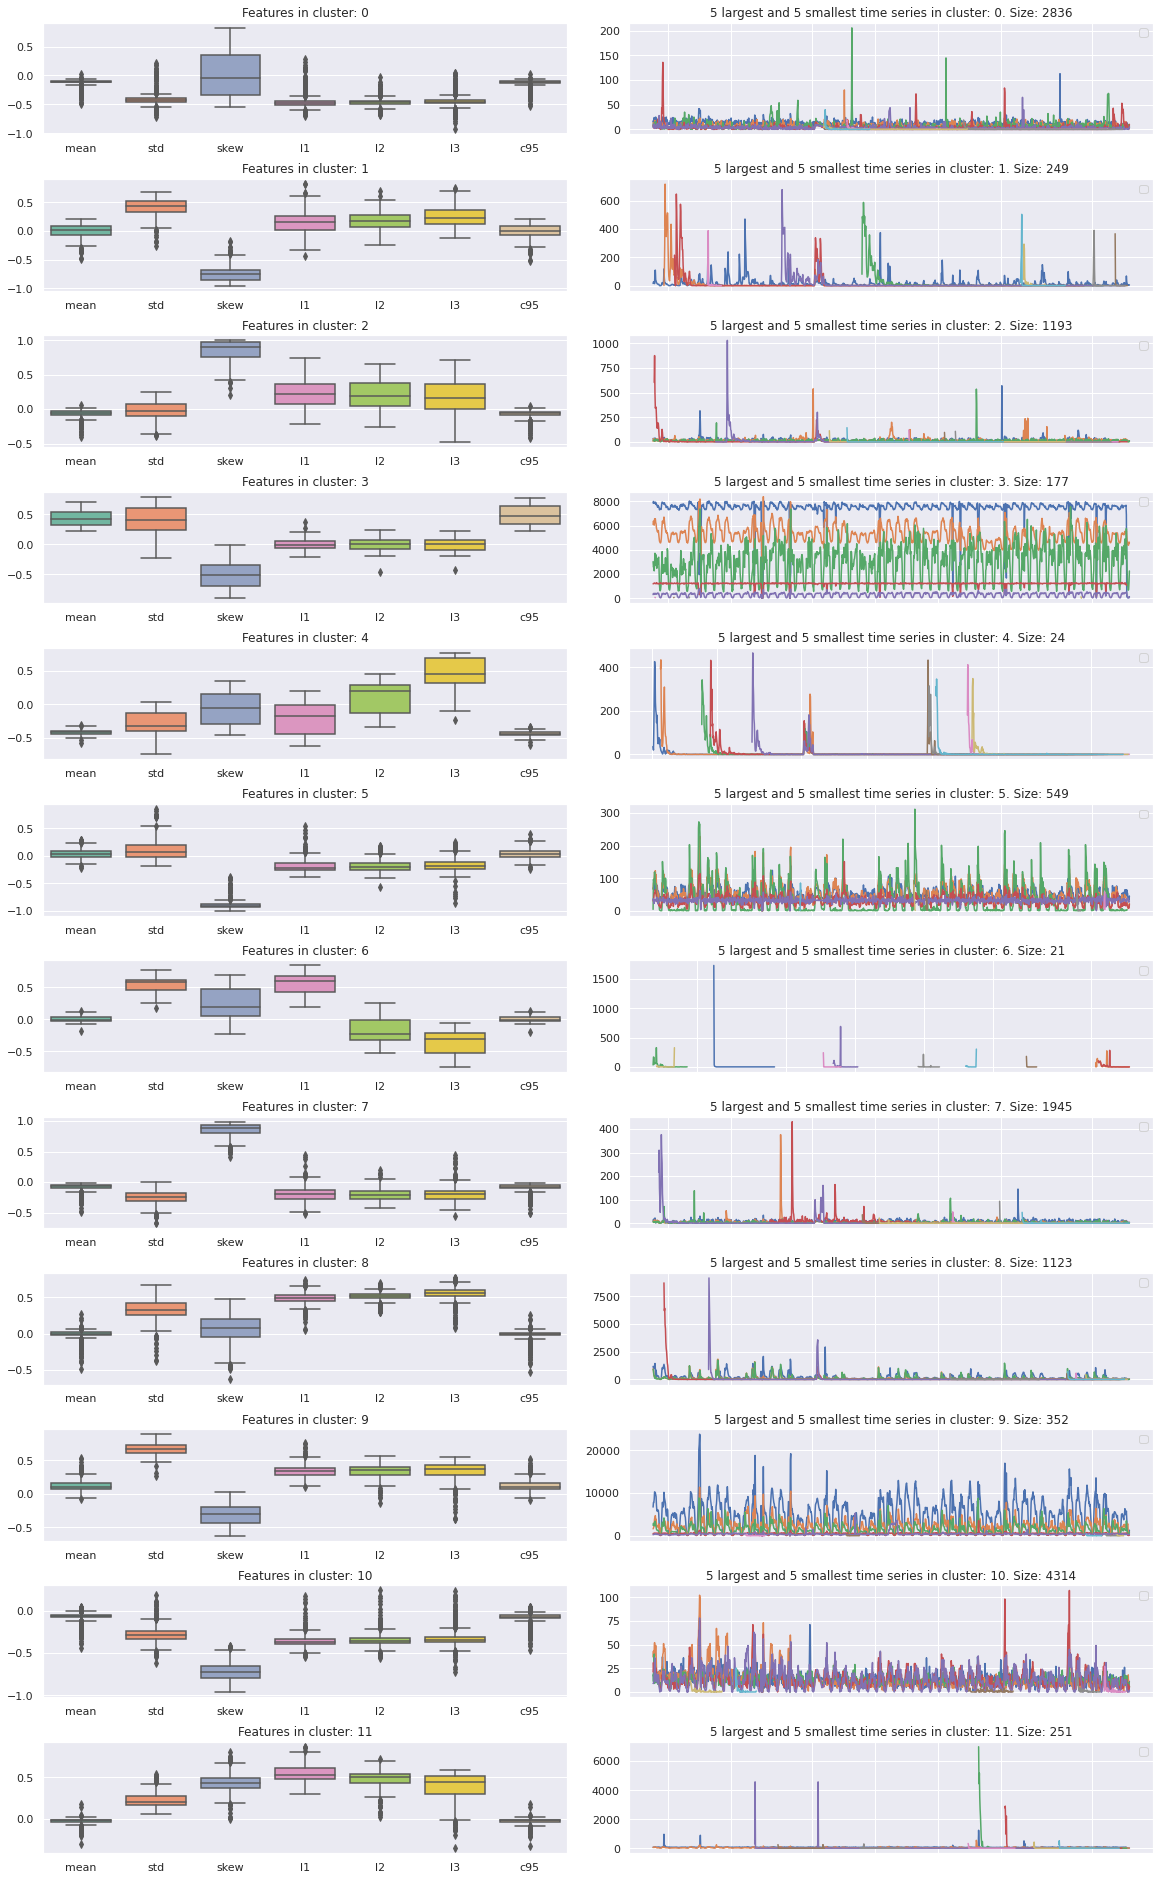

In [20]:
plot_cluster_comparison(ts_data, features_rsn, features, clusters_complete_rsn, w=16, h=26, boxplot_drop=[])

## Ward linkage

In [17]:
model_ward_rsn = fit_model(features_rsn, 'ward', 12, None)
clusters_ward_rsn = model_ward_rsn.fit_predict(features_rsn)
print(cluster_sizes(clusters_ward_rsn))

[1483  463  752  740 2439  693  841  929 1274 2500  174  746]


In [22]:
plot_cluster_comparison(ts_data, features_rsn, features, clusters_ward_rsn, w=16, h=26, boxplot_drop=[])

## Evaluation

In [23]:
# Single, average, complete, ward
features['rsn_s'] = clusters_single_rsn
features['rsn_a'] = clusters_average_rsn
features['rsn_c'] = clusters_complete_rsn
features['rsn_w'] = clusters_ward_rsn

In [24]:
cluster_evaluation = []
cluster_evaluation_data = []
cluster_group = 'rsn_c'
n_clusters = 12

In [25]:
for cluster_id in range(0, n_clusters):
    group = pd.DataFrame(features.query(f'{cluster_group} == "{cluster_id}"'))
    cluster_evaluation.append(group)
    cluster_evaluation_data.append(ts_data[ts_data['hash'].isin(group['hash'])])

In [26]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(24, 6)
for cluster_id in range(0, n_clusters):
    cluster_evaluation_data[cluster_id].groupby(['date','hours'])['count'].mean().plot(ax=ax, label=f"Cluster ({cluster_id}) mean")
ax.set_title("Cluster mean requests")
ax.legend()

In [27]:
barplot_cluster_lf = pd.DataFrame()
for cluster_id in range(0, n_clusters):
    barplot_cluster_lf[f'Cluster {cluster_id}'] = cluster_evaluation[cluster_id]['lifespan'].value_counts().sort_index().reindex(range(0, max(features['lifespan'].unique())), fill_value=0)

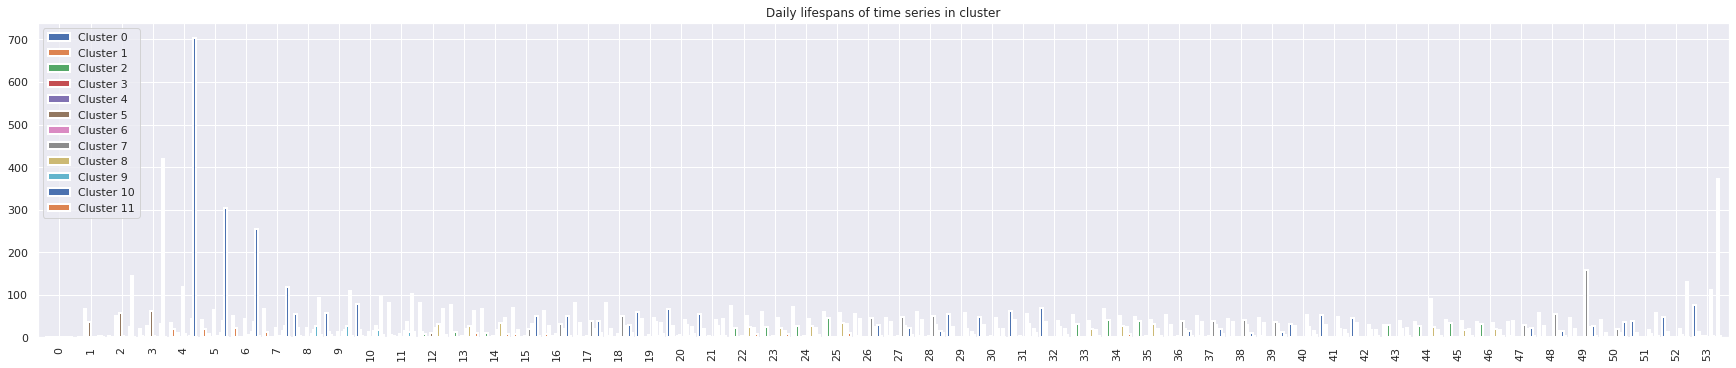

In [28]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(24, 5)
ax.set_title("Daily lifespans of time series in cluster")
barplot_cluster_lf.plot(kind='bar',ax=ax, width=0.9, linewidth=2) #color=['r','b']
ax.legend()

In [29]:
ts_group = ts_data.drop(columns=['hours','minutes']).groupby(['hash','ndt']).sum()

In [30]:
# Disabled to prevent filling RAM
for cluster_id in range(0, n_clusters):
    plot_path = f"../../../plots/{document_features_name}/{cluster_group}-c{cluster_id}"
    os.makedirs(plot_path)
    plot_cluster(cluster_id, ts_group, cluster_evaluation[cluster_id].sort_values('sum'), plot_path)

In [31]:
#!tar -czf ../../plots/c0.tar ../../plots/
#!tar -czf ../../plots/c1.tar ../../plots/c1

In [32]:
fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(16, 5)
ax.set_title("Dates in clusters")
for cluster_id in range(0, n_clusters):
    ts_data[ts_data['hash'].isin(cluster_evaluation[cluster_id]['hash'])]['date'].value_counts().sort_index()\
                           .plot(kind='bar', alpha=0.5, color=sns.color_palette("hls", n_clusters)[cluster_id], ax=ax, label=f'Cluster {cluster_id}')
ax.legend()